In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import os
import sklearn.linear_model
import matplotlib.pyplot as plt
import math
import scipy

target_directory = './resources/run_2'
target_filename = 'full'

X_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainX.csv"), delimiter=',')
Y_data = np.genfromtxt(os.path.join(target_directory, target_filename+"_trainY.csv"), delimiter=',')

print('Succesfully imported dataset with of size {0}'.format(X_data.shape))

rangefinder_bearings = np.arange(0, 20)/19.0*math.pi-math.pi/2

Succesfully imported dataset with of size (1943053, 20)


In [3]:
def evaluate_predictions(Y_data, Y_predicted):
    y_buckets = sorted(set(Y_data))
    
    d=dict()
    for b in y_buckets:
        d[b] = Y_predicted[Y_data == b]

    fig2, ax2 = plt.subplots()
    ax2.violinplot(d.values(), positions = d.keys(), showmeans = True, showextrema = False)
    ax2.set_xlabel('DP Controller')
    ax2.set_ylabel('Reactive Controller')
    ax2.set_ylim([min(y_buckets), max(y_buckets)])
    ax2.set_aspect('equal')
    plt.show()

In [4]:
def run_linear_regression(X_data, Y_data, fit_intercept = True):
    
    # we weight the samples by how aggresively the controller needs to behave, 
    #   with a small non-negative weight for everything
    # TODO: perhaps because of the nature of our data we are overweighting those situations 
    #   in which you don't encounter any obstacles?
    sample_weight = np.abs(Y_data)**6 + 0*np.max(Y_data)**4
    
    lr = sklearn.linear_model.LinearRegression(fit_intercept = fit_intercept)
    lr.fit(X_data, Y_data, sample_weight)
   
    print ("Regression weights for features = ")
    print lr.coef_
    
    print ("r-value")
    print lr.score(X_data, Y_data, sample_weight)
    
    fig1, ax1 = plt.subplots()
    ax1.scatter(rangefinder_bearings, lr.coef_)
    plt.show()

    Y_predicted = lr.predict(X_data)

    return Y_predicted

In [5]:
def run_linear_regression_transformed_Y(X_data, Y_data, fit_intercept = True):
    """
    TODO: provide better documentation
    """
    
    Yt = np.power(Y_data, 3)
       
    lr = sklearn.linear_model.LinearRegression(fit_intercept = fit_intercept)
    lr.fit(X_data, Yt)
    
    print ("Regression weights for features = ")
    print lr.coef_
    
    print ("r-value")
    print lr.score(X_data, Yt)
    
    fig1, ax1 = plt.subplots()
    ax1.scatter(rangefinder_bearings, lr.coef_)
    plt.show()

    Yt_predicted = lr.predict(X_data)
    Y_predicted = scipy.special.cbrt(Yt_predicted)
    
    return Y_predicted

Regression weights for features = 
[-0.03095658 -0.01949426 -0.02677003 -0.03462618 -0.04171019 -0.05536625
 -0.07269059 -0.08088806 -0.07962131 -0.03693672  0.03636901  0.08357396
  0.08290121  0.0689061   0.05494826  0.04255617  0.03428646  0.02521712
  0.0174142   0.02976362]
r-value
0.593026257835


<IPython.core.display.Javascript object>


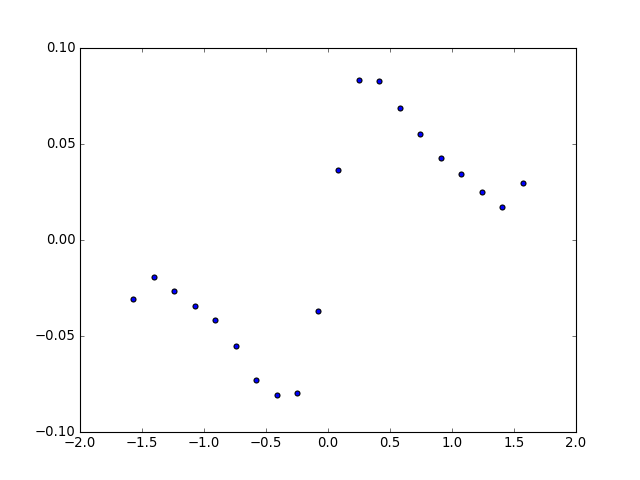

<IPython.core.display.Javascript object>


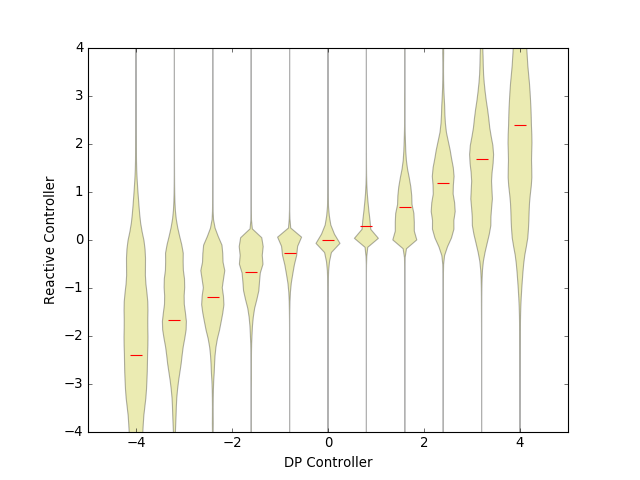

In [13]:
# linear features

Y_predicted = run_linear_regression(X_data, Y_data)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.12820739 -0.11653007 -0.18012205 -0.29509318 -0.43459486 -0.64483216
 -0.93072812 -1.14679293 -1.19636129 -0.62109231  0.61424212  1.24851301
  1.16859892  0.89921882  0.64799494  0.43062646  0.28780376  0.17586158
  0.10444544  0.13586271]
r-value
0.507934341117


<IPython.core.display.Javascript object>


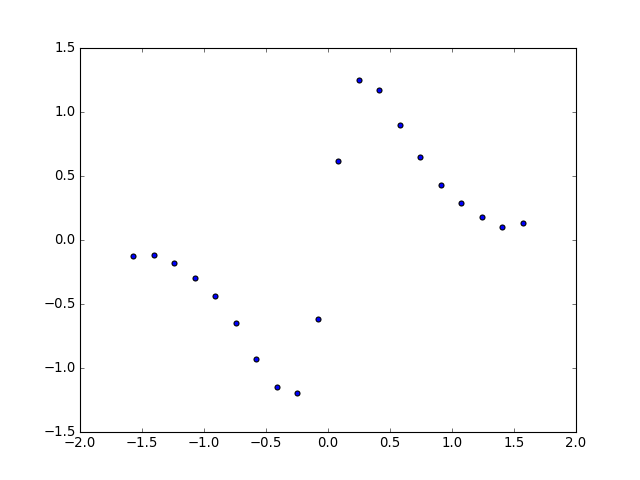

<IPython.core.display.Javascript object>


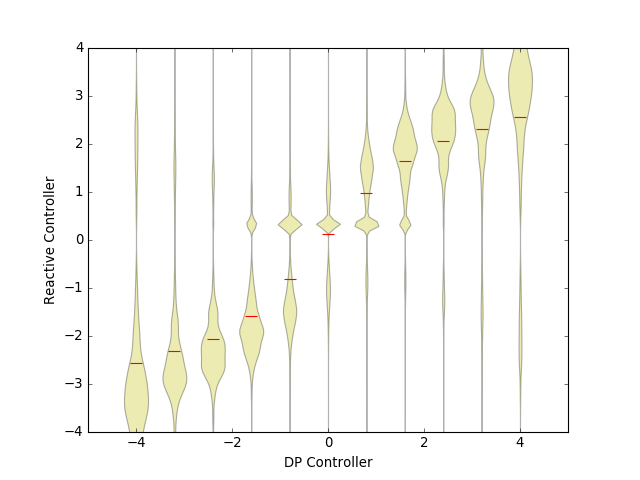

In [17]:
# cubed objective, no centering of features

Y_predicted = run_linear_regression_transformed_Y(X_data, Y_data)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[-0.12933211 -0.1168573  -0.18053814 -0.29548549 -0.43497715 -0.64520728
 -0.93109957 -1.14716128 -1.19673222 -0.62145319  0.61387357  1.24814345
  1.16823557  0.89885198  0.64761157  0.430246    0.28741517  0.17543379
  0.10411869  0.13474329]
r-value
0.507933296073


<IPython.core.display.Javascript object>


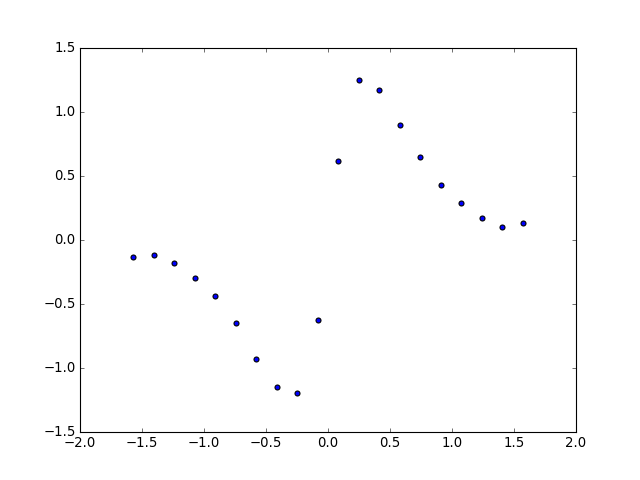

<IPython.core.display.Javascript object>


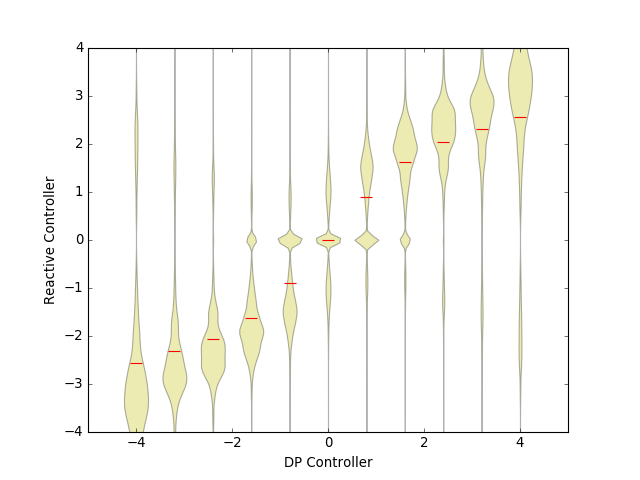

In [16]:
# cubed objective with centering of features: this forces the controller to do nothing when there are no obstacles in view.

X_centered = X_data - np.max(X_data)
Y_predicted = run_linear_regression_transformed_Y(X_centered, Y_data, fit_intercept = False)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[ 1.22008336  0.01418543  0.22027224  0.12043112  0.40301471  0.89369776
  2.19500567  2.84346501  3.44077833  1.59271026 -1.5106003  -3.55754617
 -2.95568622 -1.99611833 -0.9445429  -0.45344862 -0.17444108  0.01370327
 -0.16129159 -1.04630946]
r-value
0.268998018055


<IPython.core.display.Javascript object>


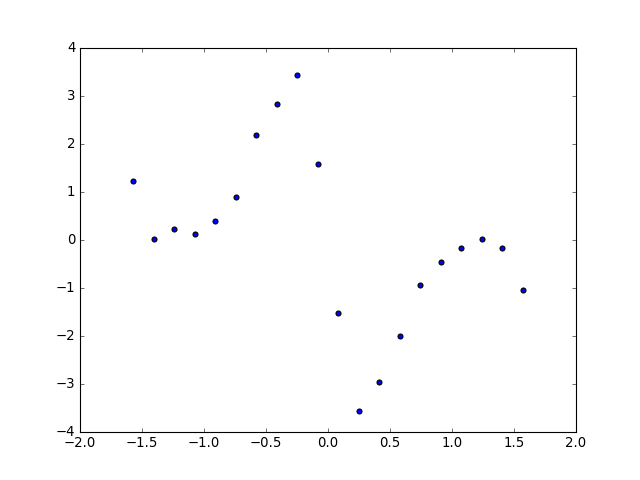

<IPython.core.display.Javascript object>


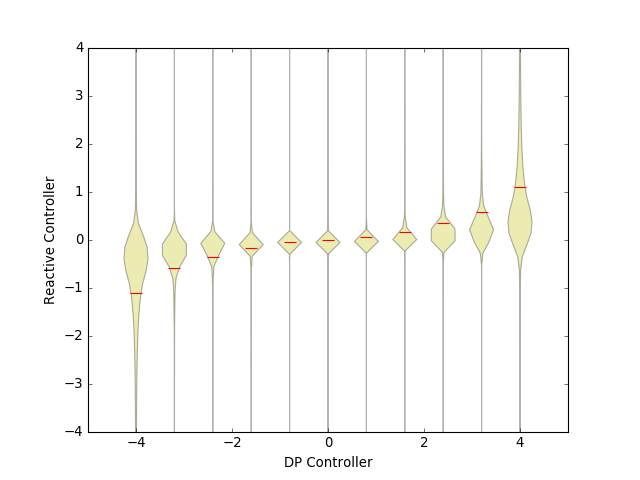

In [18]:
# attempt at inverse controller. It's not so good.

X_features = X_data**(-1)
cap = np.array([1])
X_capped = np.minimum(cap, X_features)
Y_predicted = run_linear_regression(X_capped, Y_data)
evaluate_predictions(Y_data, Y_predicted)

Regression weights for features = 
[ -5.53676949e-05  -4.63624095e-05  -6.37208294e-05  -8.40930757e-05
  -1.04014732e-04  -1.30922095e-04  -1.56299016e-04  -1.61956617e-04
  -1.45237331e-04  -6.54131248e-05   6.57022271e-05   1.53581106e-04
   1.66136066e-04   1.51075808e-04   1.29975388e-04   1.04856655e-04
   8.31947490e-05   6.05600236e-05   4.13028094e-05   5.37090359e-05]
r-value
0.645686759281


<IPython.core.display.Javascript object>


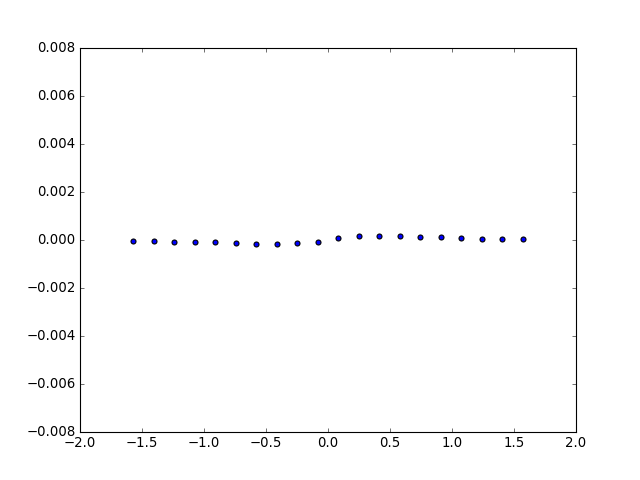

<IPython.core.display.Javascript object>


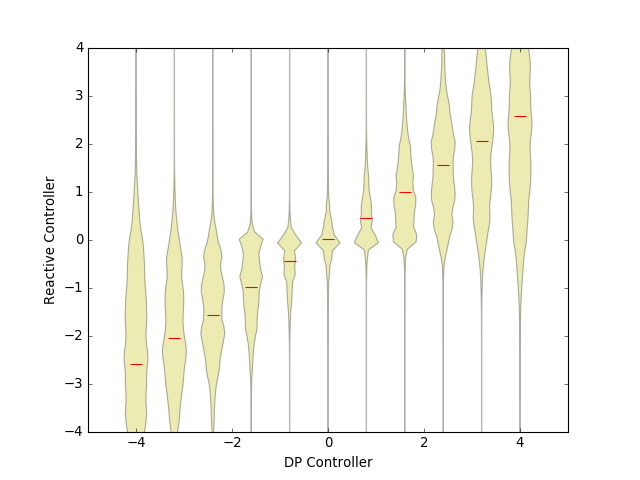

In [19]:
# cubed features. 

X_features = X_data**(3)
Y_predicted = run_linear_regression(X_features, Y_data)
evaluate_predictions(Y_data, Y_predicted)